## Import Libraries

In [459]:
from tensorflow import keras
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [460]:
pd.set_option('display.max_rows', 50)

## Import Datasets

In [461]:
train_data = pd.read_csv("Kaggle_Dataset/PM_train.txt", sep=" ", header=None)
test_data = pd.read_csv("Kaggle_Dataset/PM_test.txt", sep=" ", header=None)
ground_truth = pd.read_csv("Kaggle_Dataset/PM_truth.txt", sep=" ", header=None)

### Drop Empty Columns

In [462]:
train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)
ground_truth.dropna(axis=1, inplace=True)

### Label Columns

In [463]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_data.columns = cols_names
test_data.columns = cols_names

### Sort columns by the attributes 'id' and 'cycle'

In [464]:
train_data = train_data.sort_values(['id', 'cycle'])
test_data = test_data.sort_values(['id', 'cycle'])

### Normalize training data in all columns that are different to 'id' and 'cycle'

In [465]:
norm_cols = train_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_train_data = pd.DataFrame(min_max_scaler.fit_transform(train_data[norm_cols]), 
                               columns=norm_cols, index=train_data.index)

join_train_data = train_data[["id", "cycle"]].join(norm_train_data)

train_data = join_train_data.reindex(columns = train_data.columns)

norm_cols = test_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_test_data = pd.DataFrame(min_max_scaler.fit_transform(test_data[norm_cols]), 
                               columns=norm_cols, index=test_data.index)

join_test_data = test_data[["id", "cycle"]].join(norm_test_data)

test_data = join_test_data.reindex(columns = test_data.columns)

In [466]:
def create_rul_column(data):
    rul = pd.DataFrame(data.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    data = data.merge(rul, on=['id'], how='left')
    data['RUL'] = data['max'] - data['cycle']
    data.drop('max', axis=1, inplace=True)
    return data

train_data = create_rul_column(train_data)
test_data = create_rul_column(test_data)

In [467]:
# smooth the data using rolling average on sensors
omit_cols = ['id', 'cycle', 'RUL']
sensor_cols = train_data.columns.difference(omit_cols)

train_data_smooth = train_data.copy()
train_data_smooth.loc[:, sensor_cols] = train_data_smooth.loc[:, sensor_cols].rolling(window=5).median()
train_data_smooth = train_data_smooth.fillna(train_data)
train_data = train_data_smooth

test_data_smooth = test_data.copy()
test_data_smooth.loc[:, sensor_cols] = test_data_smooth.loc[:, sensor_cols].rolling(window=5).median()
test_data_smooth = test_data_smooth.fillna(test_data)
test_data = test_data_smooth

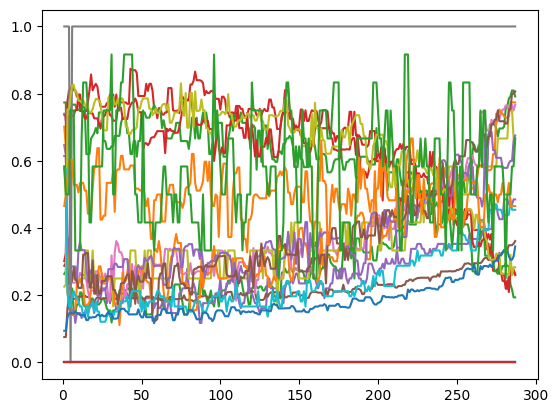

In [468]:
# EDA

# Create a new feature called "time to failure" which is the inverse of RUL
train_data['TTF'] = 1 / (train_data['RUL'] + 1)
test_data['TTF'] = 1 / (test_data['RUL'] + 1)

# Plot dynamic sensor data
for i in train_data.columns.difference(['id', 'cycle', 'RUL']):
    plt.plot(train_data[train_data["id"] == 2]["cycle"], train_data[i][train_data["id"] == 2], label=i)
    #print(i)
plt.show()

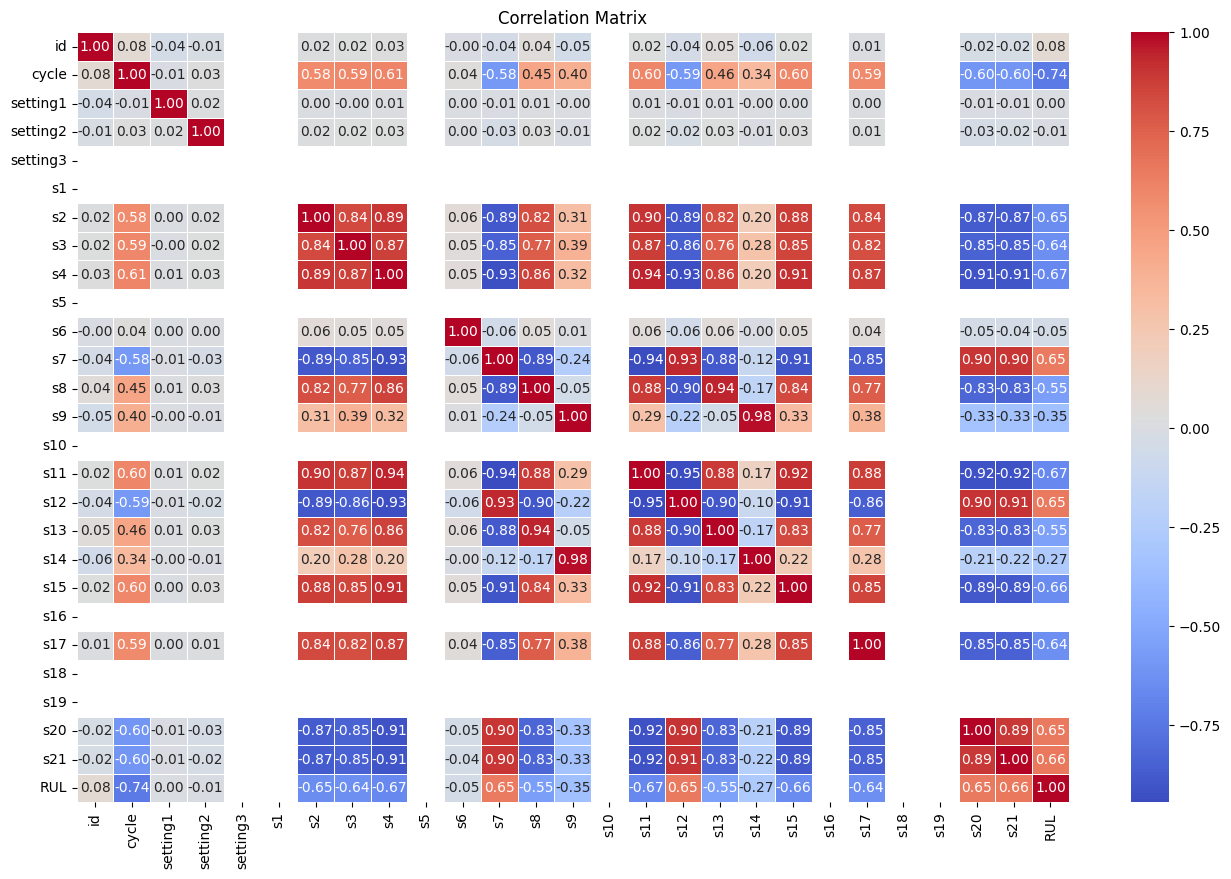

In [469]:
# Compute the correlation matrix
corr = train_data.corr()

# Generate a heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

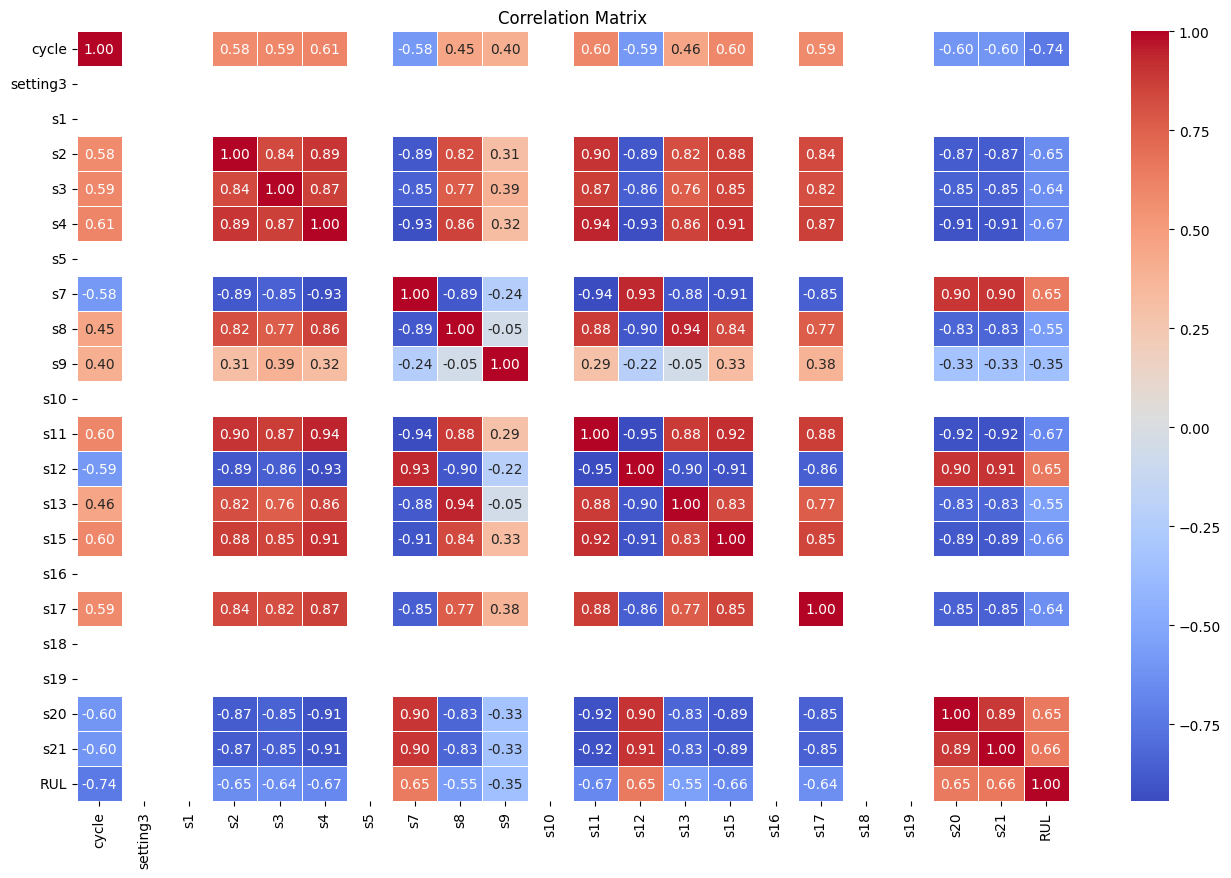

In [470]:
# Remove features with low correlation to RUL
low_corr_cols = corr[corr["RUL"].abs() < 0.3].index
train_data.drop(low_corr_cols, axis=1, inplace=True)
test_data.drop(low_corr_cols, axis=1, inplace=True)

corr = train_data.corr()

# Remove features with high correlation to each other
high_corr_cols = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            high_corr_cols.add(corr.columns[i])

train_data.drop(high_corr_cols, axis=1, inplace=True)
test_data.drop(high_corr_cols, axis=1, inplace=True)

plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [471]:
# Set up the data for the model
X_train = train_data.drop(['RUL'], axis=1)
X_test = test_data.drop(['RUL'], axis=1)

y_train = train_data['RUL']
y_test = test_data['RUL']

In [472]:
# Training the model	
#model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, max_features=2, n_jobs=-1, verbose=1) # r2 = 0.033, rmse = 52.17

#history = model.fit(X_train, y_train)

In [473]:
#model = GradientBoostingRegressor(n_estimators=10, max_depth=7, random_state=42, max_features='sqrt', verbose=1) # r2 = 0.023, rmse = 52.44

#history = model.fit(X_train, y_train)

In [474]:
# Define a threshold
threshold = 30

# Create a new target variable based on the threshold
y_train_class = [1 if i >= threshold else 0 for i in y_train]
y_test_class = [1 if i >= threshold else 0 for i in y_test]

# Convert to dataframe
y_train_class = pd.DataFrame(y_train_class, columns=['RUL'])
y_test_class = pd.DataFrame(y_test_class, columns=['RUL'])

# Now you can use a classification model
from sklearn.ensemble import RandomForestClassifier
#              precision    recall  f1-score   support

#           0       0.79      0.25      0.38      3000
#           1       0.81      0.98      0.89     10096

#    accuracy                           0.81     13096
#   macro avg       0.80      0.61      0.63     13096
#weighted avg       0.81      0.81      0.77     13096
#classifier = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42, max_features='sqrt', n_jobs=-1, verbose=1)
#classifier.fit(X_train, y_train_class)
classifier = keras.models.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train_class, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.7998 - loss: 0.6281 - val_accuracy: 0.7708 - val_loss: 0.4313
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.8535 - loss: 0.3305 - val_accuracy: 0.8226 - val_loss: 0.3573
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.8837 - loss: 0.2632 - val_accuracy: 0.9028 - val_loss: 0.2316
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.8990 - loss: 0.2359 - val_accuracy: 0.9368 - val_loss: 0.1690
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.9218 - loss: 0.1911 - val_accuracy: 0.9535 - val_loss: 0.1378
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.9286 - loss: 0.1735 - val_accuracy: 0.9494 - val_loss: 0.1274
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.9411 - loss: 0.1474 - val_accuracy: 0.9254 - val_loss: 0.1618
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.9383 - loss: 0.1404 - 

410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
(10311,)


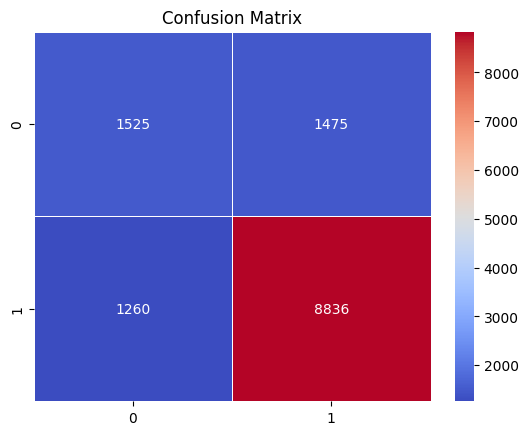

              precision    recall  f1-score   support

           0       0.55      0.51      0.53      3000
           1       0.86      0.88      0.87     10096

    accuracy                           0.79     13096
   macro avg       0.70      0.69      0.70     13096
weighted avg       0.79      0.79      0.79     13096



In [475]:
# Predict the classes for the test set
y_pred_prob = classifier.predict(X_test)

y_pred_class = (y_pred_prob > 0.5).astype("int32")

print(y_pred_class[y_pred_class == 1].shape)

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_class, y_pred_class)

sns.heatmap(confusion_matrix(y_test_class, y_pred_class), annot=True, fmt='d', cmap='coolwarm', linewidths=0.5)
plt.title('Confusion Matrix')
plt.show()

# Compute the classification report
from sklearn.metrics import classification_report

print(classification_report(y_test_class, y_pred_class))

